# Further investigate which `windowSize` parameters tend to give best `R` when `alpha` fixed at 0.5

In [1]:
library(CpGWAS)

In [2]:
# Want big view for facet plots
options(repr.plot.width=10, repr.plot.height=8)

In [3]:
scaff_paths <- list.files("../output/", pattern = "rds", full.names = TRUE, recursive = TRUE)

extract_info <- function(path) {
  matches <- regmatches(path, regexpr("\\d{8}-\\d{6}", path))
  if (length(matches) > 0) {
    datetime <- strsplit(matches, "-")[[1]]
    date <- paste(substr(datetime[1], 1, 4), substr(datetime[1], 5, 6), substr(datetime[1], 7, 8), sep="-")
    time <- paste(substr(datetime[2], 1, 2), substr(datetime[2], 3, 4), substr(datetime[2], 5, 6), sep=":")
    return(c(date, time))
  } else {
    return(c(NA, NA))
  }
}

data_frame <- do.call(rbind, lapply(scaff_paths, function(path) {
  info <- extract_info(path)
  data.frame(path = path, date = info[1], time = info[2], stringsAsFactors = FALSE)
}))

sorted_data_frame <- data_frame[order(data_frame$date, data_frame$time), ]

In [4]:
sorted_data_frame <- tail(sorted_data_frame, 80)

In [5]:
scaff_paths <- sorted_data_frame$path

In [6]:
convertToDataFrame <- function(object) {
  if (!inherits(object, "MethylationScaff")) {
    stop("The object must be of class 'MethylationScaff'.")
  }

  modelsList <- lapply(object@models, function(model) {
    data.frame(
      scaffoldIdentifier = object@scaffoldIdentifier,
      methylationPosition = model@methylationPosition,
      windowSize = model@windowSize,
      nSNPs = model@n_SNPs,
      cor = model@evaluation_results['cor'],
      mse = model@evaluation_results['mse'],
      alpha = model@alpha,
      lambda = model@lambda
    )
  })

  do.call("rbind", modelsList)
}

In [7]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
df <- data.frame()

In [9]:
for(scaff_path in scaff_paths){
    my_scaff <- readRDS(scaff_path)
    small_df <- convertToDataFrame(my_scaff)
    df <- bind_rows(df, small_df)
}

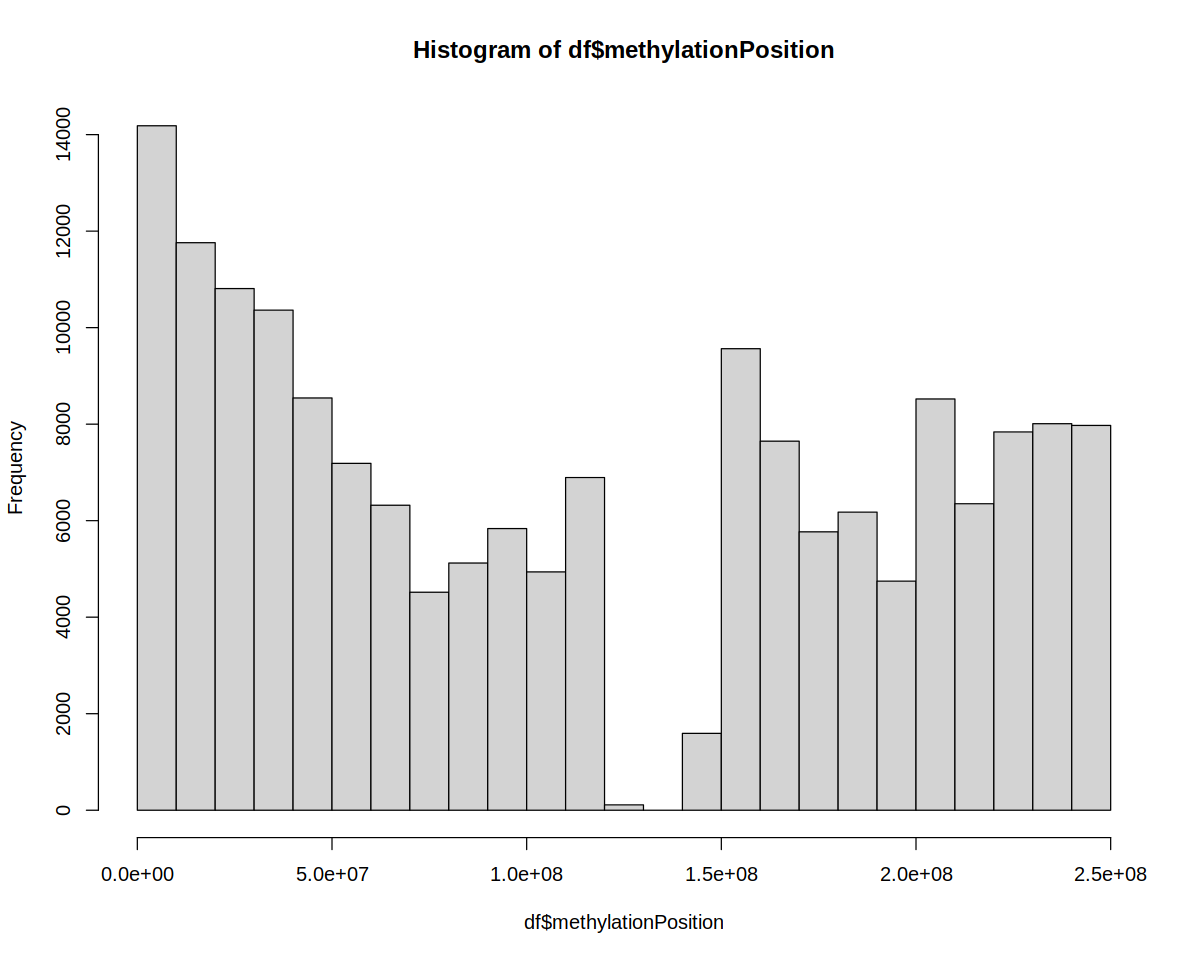

In [10]:
hist(df$methylationPosition)

I'm guessing that's the centromere in the middle

Let's get the first and last SNP positions

In [11]:
start_pos <- min(df$methylationPosition)
end_pos <- max(df$methylationPosition)

In [12]:
start_pos

[1] 795635

In [13]:
end_pos

[1] 248906249

In [14]:
head(levels(factor(df$methylationPosition))) # make sure these don't all end in 0

[1] "795635" "832079" "834506" "844858" "901841" "903189"

What percentage of models have all coefficients dropped during regularization?

In [15]:
sum(is.na(df$cor))/dim(df)[1]

[1] 0.06253696

In [16]:
coverage_summary <- as.data.frame(table(df$windowSize))
colnames(coverage_summary) <- c("windowSize", "percentage_sites_covered")
coverage_summary$percentage_sites_covered <- 
(coverage_summary$percentage_sites_covered / 10000) * 100

What percentage of methylation sites have SNPs within defined window of each given size?

In [17]:
coverage_summary$percentage_sites_uncovered <- 100 - coverage_summary$percentage_sites_covered

In [18]:
coverage_summary

windowSize,percentage_sites_covered,percentage_sites_uncovered
<fct>,<dbl>,<dbl>
2000,82.93,17.07
4000,91.03,8.97
6000,92.62,7.38
8000,93.11,6.89
10000,93.40,6.60
20000,94.14,5.86
40000,95.09,4.91
60000,95.45,4.55
80000,95.71,4.29


<div class="alert alert-block alert-info">Note trend. 93.4% coverage for 10kb window vs. 97.7% coverage for 500kb window </div>

## Which `window_size`s tend to give most `NA` for `R` value?

We get `NA` values for `R` when all SNPs are dropped during regularization.

In [19]:
library(dplyr)
library(ggplot2)

na_percentage.2 <- df %>%
  mutate(alpha = factor(alpha, labels = paste("alpha =", levels(factor(alpha)))),
         windowSize = factor(windowSize, labels = levels(factor(windowSize)))) %>%
  group_by(alpha, windowSize) %>%
  summarise(PercentageNA = mean(is.na(cor)) * 100, .groups = 'drop')

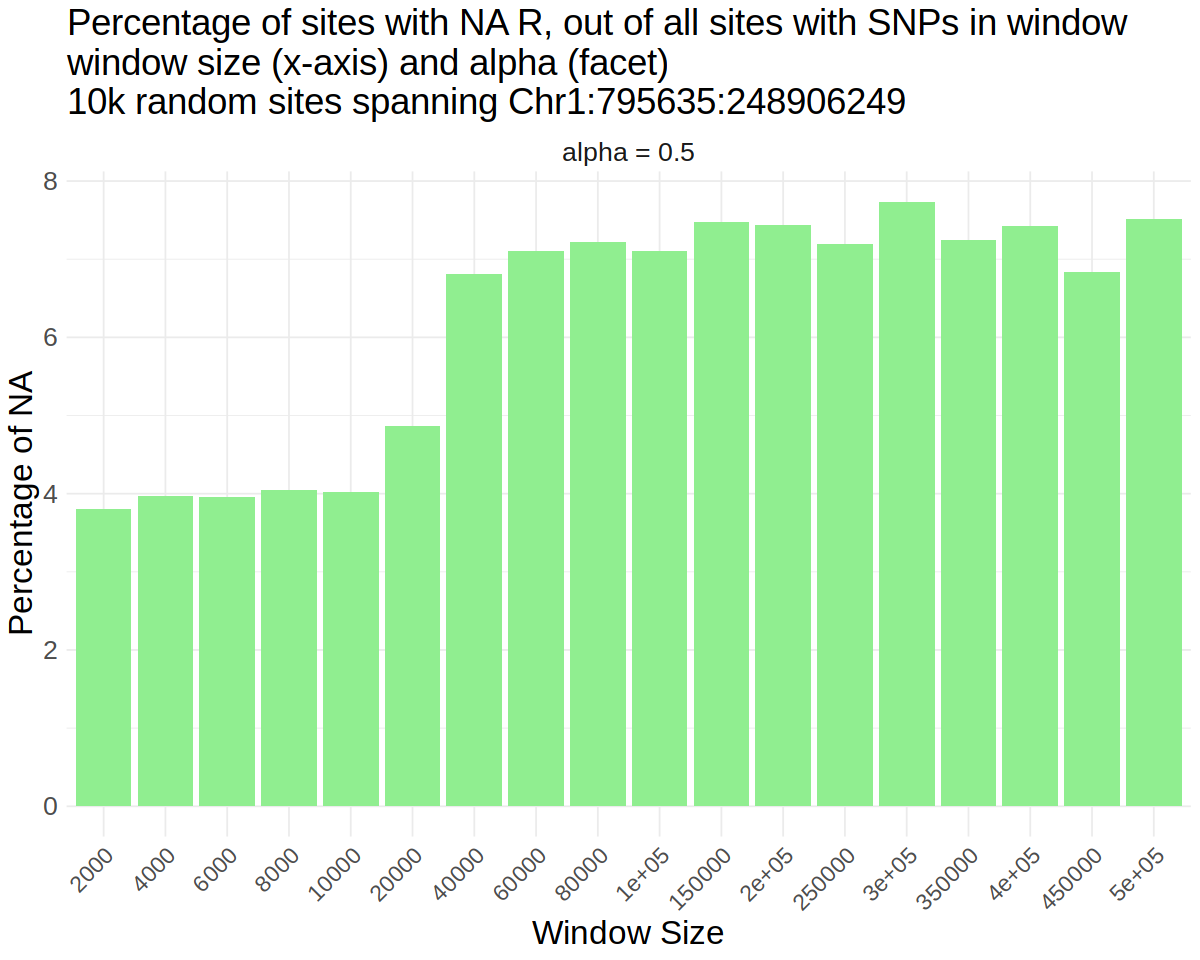

In [20]:
ggplot(na_percentage.2, aes(x = as.factor(windowSize), y = PercentageNA)) +
  geom_bar(stat = "identity", fill = "lightgreen") +
  #geom_text(aes(label = sprintf("%.2f%%", PercentageNA)), vjust = -1, hjust = 0.5, angle = 45) +
  facet_wrap(~alpha) +
  theme_minimal() +
  labs(title = paste0("Percentage of sites with NA R, out of all sites with SNPs in window\nwindow size (x-axis) and alpha (facet)\n10k random sites spanning Chr1:",
                      start_pos, ":", end_pos), x = "Window Size", y = "Percentage of NA") +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14)
  )

<div class="alert alert-block alert-info">Keep in mind, the stats in the plot are for the percentage of sites for which we DO have SNPs within given window. </div>

In [21]:
# Aggregate to count NA values by 'alpha' and 'windowSize'

#df$alpha <- as.factor(df$alpha)
#df$windowSize <- as.factor(df$windowSize)

df$na_cor <- is.na(df$cor)

na_count <- aggregate(na_cor ~ alpha + windowSize, data = df, FUN = sum)

names(na_count)[names(na_count) == "na_cor"] <- "CountNA"

na_count$percentage_NA_out_of_total <- na_count$CountNA / 10000 * 100

In [22]:
merged <- merge(coverage_summary, na_count)

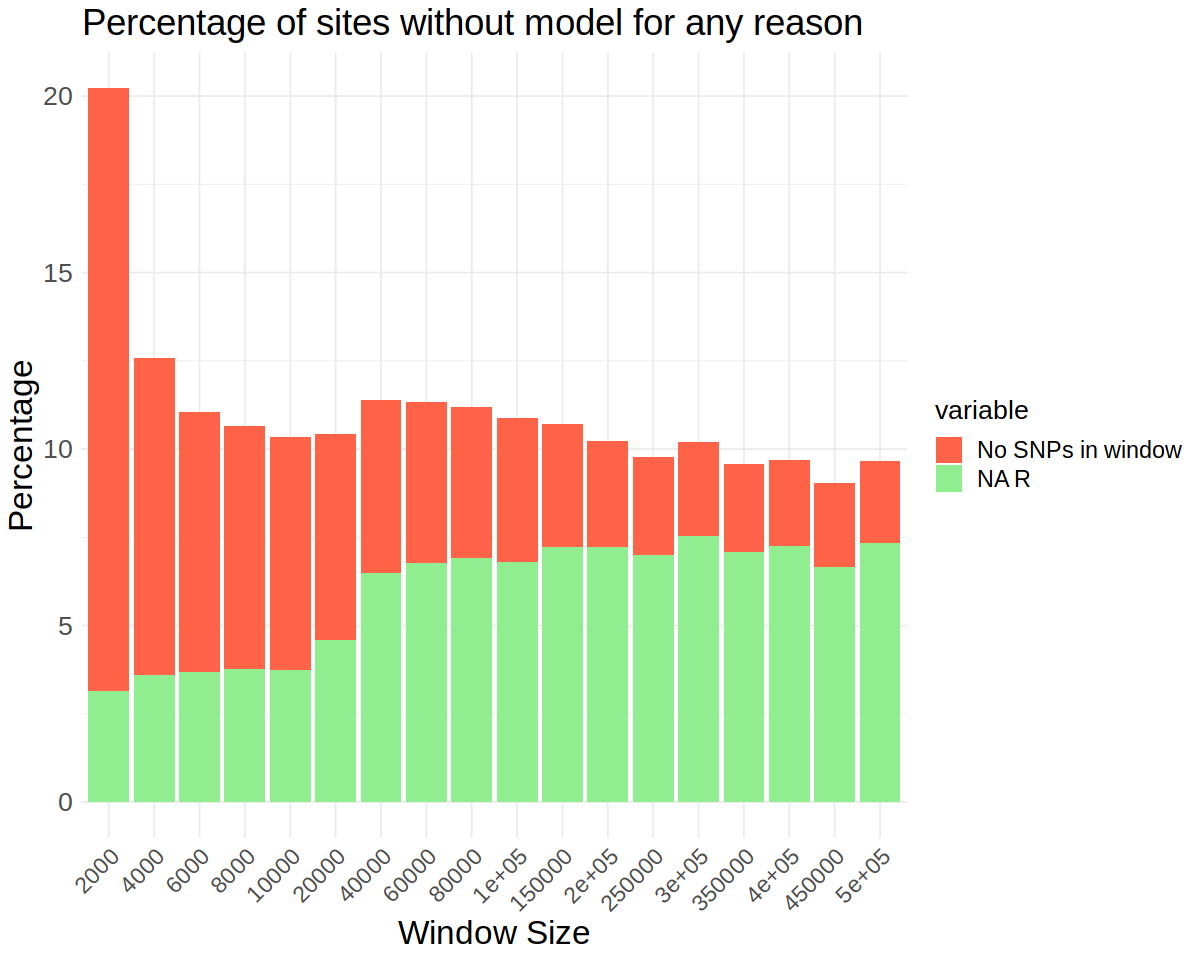

In [23]:
library(ggplot2)
library(reshape2)

# Assuming 'merged' is your data.frame
# Reshape the data to long format
merged_melted <- melt(merged, id.vars = c("windowSize", "alpha"), measure.vars = c("percentage_sites_uncovered", "percentage_NA_out_of_total"))

# Rename the variable and value
merged_melted$variable <- factor(merged_melted$variable, levels = c("percentage_sites_uncovered", "percentage_NA_out_of_total"),
                                  labels = c("No SNPs in window", "NA R"))

# Now plot
ggplot(merged_melted, aes(x = as.factor(windowSize), y = value, fill = variable)) +
  geom_bar(stat = "identity") +
  labs(title = "Percentage of sites without model for any reason", 
       x = "Window Size", 
       y = "Percentage") +
  theme_minimal() +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  ) +
  scale_fill_manual(values = c("No SNPs in window" = "tomato", "NA R" = "lightgreen"))


## See which have best `alpha`, `window_size` tend to give best R (`cor`)

Warning message:
“Removed 10680 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10680 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 10680 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 10680 rows containing missing values (`geom_point()`).”


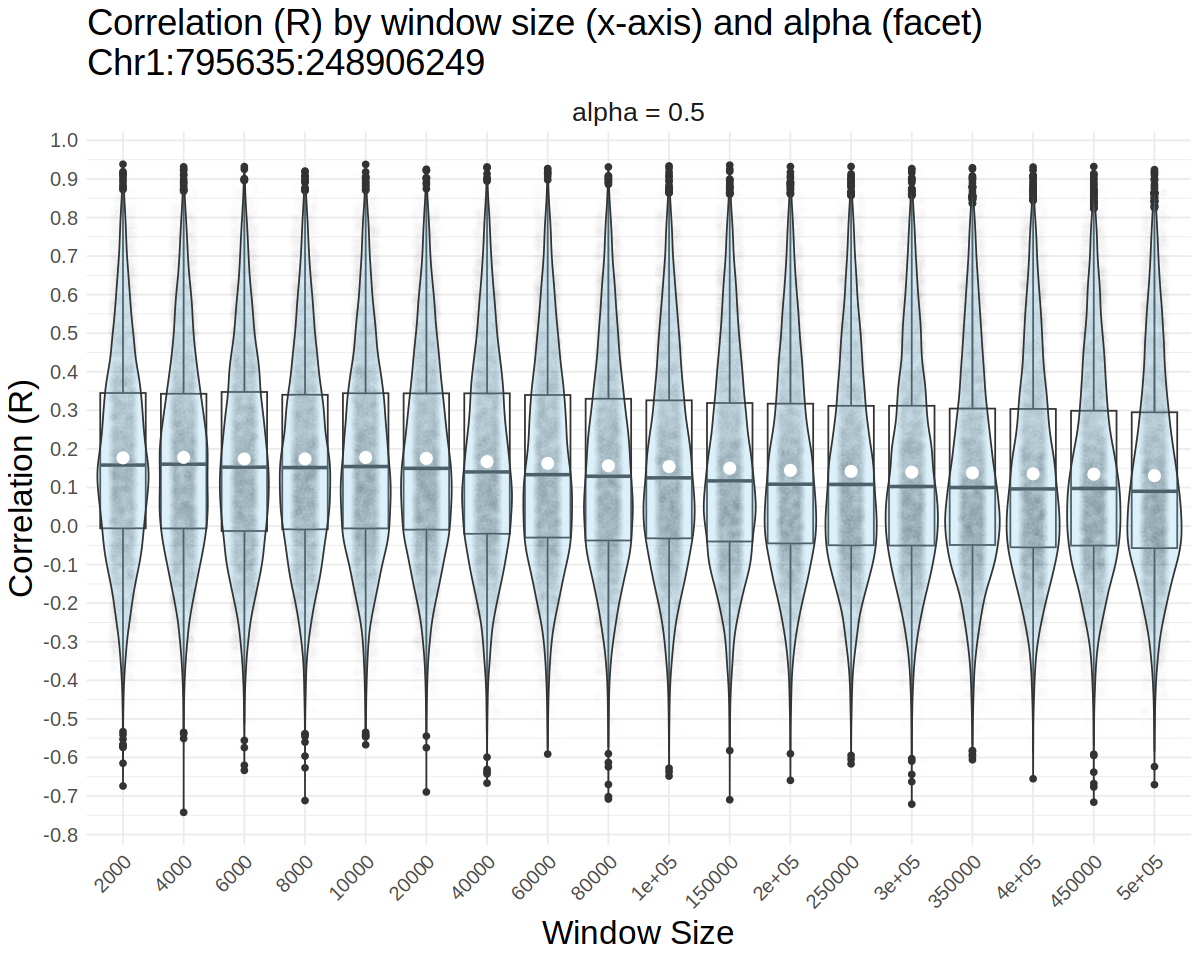

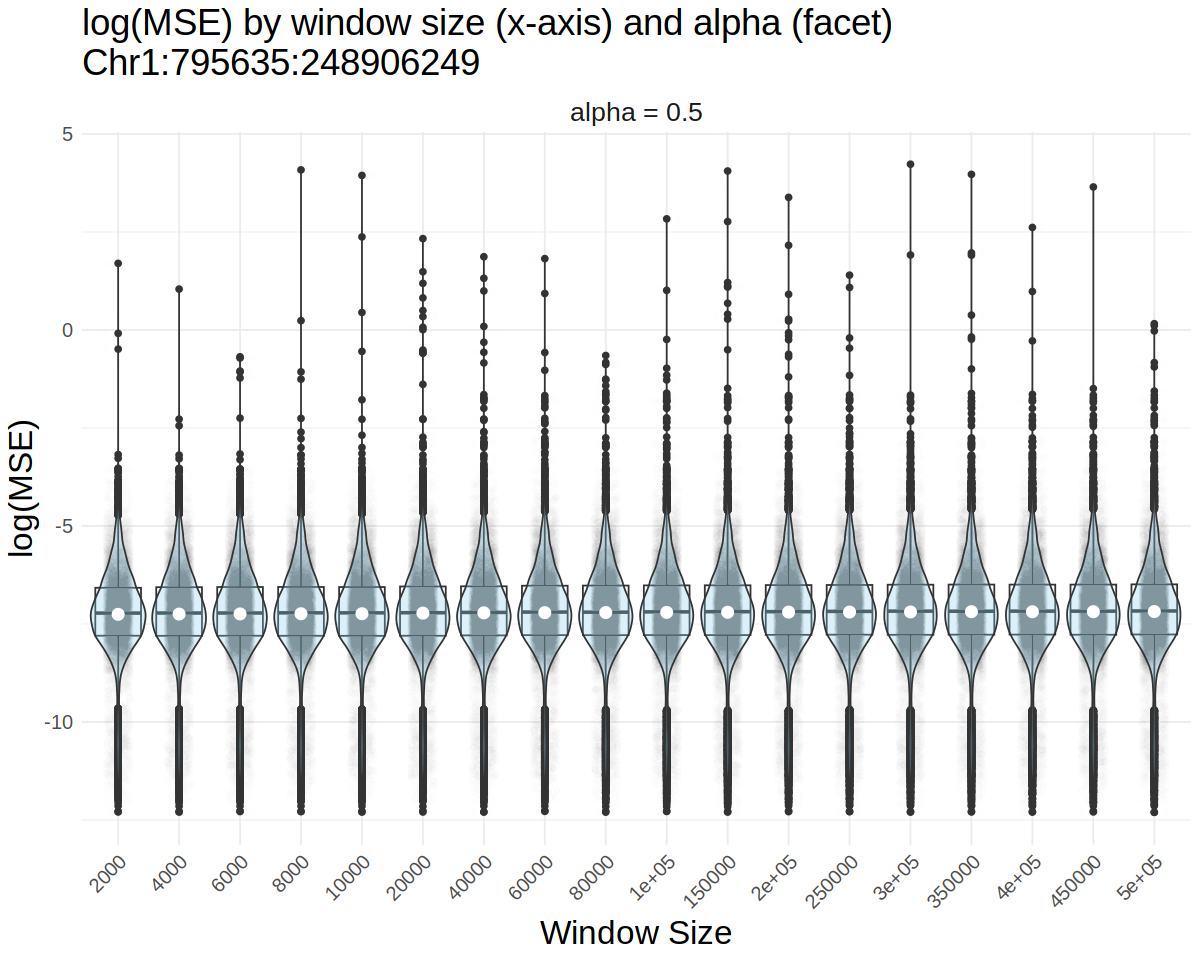

In [60]:
library(dplyr)
library(ggplot2)

df_formatted.2 <- df %>%
  mutate(alpha = factor(alpha, labels = paste("alpha =", levels(factor(alpha)))),
         windowSize = factor(windowSize, labels = paste(levels(factor(windowSize)))))

p_windowSize_formatted <- ggplot(df_formatted.2, aes(x = windowSize, y = cor)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.005) +
  geom_violin(fill = "skyblue", alpha = 0.3) +
  stat_summary(fun = mean, geom = "point", color = "white", shape = 21, size = 3, fill = "white") + # This adds the mean
  facet_wrap(~alpha) +
  theme_minimal() +
  labs(title = paste0("Correlation (R) by window size (x-axis) and alpha (facet)\nChr1:",
                      start_pos, ":", end_pos), x = "Window Size", y = "Correlation (R)") +
  scale_y_continuous(breaks = seq(floor(min(df_formatted.2$cor, na.rm = TRUE)), ceiling(max(df_formatted.2$cor, na.rm = TRUE)), by = 0.1)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12),
    axis.text.y = element_text(size = 12)
  )

#print(p_alpha_formatted)
print(p_windowSize_formatted)

p_windowSize_formatted <- ggplot(df_formatted.2, aes(x = windowSize, y = log(mse))) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.005) +
  geom_violin(fill = "skyblue", alpha = 0.3) +
  stat_summary(fun = mean, geom = "point", color = "white", shape = 21, size = 3, fill = "white") + # This adds the mean
  facet_wrap(~alpha) +
  theme_minimal() +
  labs(title = paste0("log(MSE) by window size (x-axis) and alpha (facet)\nChr1:",
                      start_pos, ":", end_pos), x = "Window Size", y = "log(MSE)") +
  #ylim(0, 0.2) +
  #scale_y_continuous(breaks = seq(floor(min(df_formatted.2$mse, na.rm = TRUE)), ceiling(max(df_formatted.2$cor, na.rm = TRUE)), by = 0.1)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12),
    axis.text.y = element_text(size = 12)
  )

#print(p_alpha_formatted)
print(p_windowSize_formatted)


<div class="alert alert-block alert-info">It appears we can again see a trend of decreasing R with window size. However, as shown above, there's a more complex effect of window size on the percentage of sites for which we're able to compute R. </div>

# Track trends of changes in `alpha`, `window_size` for `cor` of specific given CpG sites

## By plotting

#### Without scaling `cor`

In [25]:
convert_and_order_windowSizes <- function(df, windowSizeColumn = 'windowSize') {
  convert_to_genetic_terms <- function(size) {
    if (size >= 1e6) {
      return(paste0(size / 1e6, "Mb"))
    } else if (size >= 1e3) {
      return(paste0(size / 1e3, "kb"))
    } else {
      return(paste0(size, "bp"))
    }
  }
  
  # Ensure windowSizeColumn is numeric for ordering
  df[[windowSizeColumn]] <- as.numeric(df[[windowSizeColumn]])
  
  # Order the dataframe by the numeric window size
  df <- df[order(df[[windowSizeColumn]]), ]
  
  # Apply the genetic terms conversion
  df$windowSizeLabel <- sapply(df[[windowSizeColumn]], convert_to_genetic_terms)
  
  return(df)
}

# Assuming df's windowSizeColumn is already numeric and properly named 'windowSize'
df <- convert_and_order_windowSizes(df, 'windowSize')


### Statistical models

#### Across all window sizes

##### Effect of window size on R

Let's start with a simple linear model and ANOVA to see if we're able to detect any difference across groups for window size, alpha, and interaction.

In [26]:
model <- lm(cor ~ windowSize,
            data = df)

In [27]:
model


Call:
lm(formula = cor ~ windowSize, data = df)

Coefficients:
(Intercept)   windowSize  
  1.716e-01   -9.540e-08  


In [28]:
anova(model)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
windowSize,1,40.29869,40.29868995,605.9683,1.495772e-133
Residuals,160097,10646.92485,0.06650296,NA,NA


<div class="alert alert-block alert-info">Yes, clear effect of window size on R</div>

##### Effect of window size on MSE

In [61]:
model <- lm(mse ~ windowSize,
            data = df)

In [62]:
model


Call:
lm(formula = mse ~ windowSize, data = df)

Coefficients:
(Intercept)   windowSize  
  4.403e-03    2.623e-09  


In [63]:
anova(model)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
windowSize,1,3.252534e-02,0.03252534,0.2661722,0.6059118
Residuals,170777,2.086837e+04,0.12219662,NA,NA


<div class="alert alert-block alert-info">No effect of window size on MSE detected</div>

#### If we subset to 10 and below

##### Effect of window size on R

In [48]:
subset_df <- df[which(df$windowSize <= 10000), ]

In [49]:
model <- lm(cor ~ windowSize,
            data = subset_df)

In [50]:
model


Call:
lm(formula = cor ~ windowSize, data = subset_df)

Coefficients:
(Intercept)   windowSize  
  1.766e-01   -8.779e-08  


In [51]:
anova(model)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
windowSize,1,2.630681e-03,0.002630681,0.04092287,0.8396878
Residuals,43512,2.797120e+03,0.064283881,NA,NA


<div class="alert alert-block alert-info">Reducing window size below 10kb, we do not detect a significant effect of window size on R.</div>

## What's the relationship between SNP effect size and distance from methylation site... and how does this depend on window size?

First, extract all SNP coefficients, IDs, and corresponding methylation sites for our models.<br><br>Let's only make this df for one window size at a time, for fair comparisons.

In [29]:
SNPs_to_df <- function(object) {
  modelsList <- lapply(object@models, function(model) {
    snpIDs <- names(model@snpWeights)
    snpWeights <- model@snpWeights

    expandedModelAttrs <- data.frame(
      scaffoldIdentifier = rep(object@scaffoldIdentifier, length(snpIDs)),
      methylationPosition = rep(model@methylationPosition, length(snpIDs)),
      windowSize = rep(model@windowSize, length(snpIDs)),
      SNP_ID = snpIDs,
      SNP_Weight = snpWeights,
      cor = rep(model@evaluation_results[['cor']], length(snpIDs))
    )

    return(expandedModelAttrs)
  })

  df <- do.call("rbind", modelsList)
  
  df <- convert_and_order_windowSizes(df, 'windowSize')
  
  return(df)
}

In [30]:
snp_df <- data.frame()

In [31]:
for(scaff_path in scaff_paths){
    my_scaff <- readRDS(scaff_path)
    small_snp_df <- SNPs_to_df(my_scaff)
    snp_df <- bind_rows(snp_df, small_snp_df)
}

In [32]:
snp_df$SNP_Position <- as.numeric(gsub(".*:(\\d+):.*", "\\1", snp_df$SNP_ID))
snp_df$Distance = abs(snp_df$methylationPosition - snp_df$SNP_Position)


In [33]:
dim(snp_df)

[1] 411101      9

In [34]:
r_squared_df <- snp_df %>%
  group_by(windowSize) %>%
  do({
    model <- lm(cor ~ Distance, data = .)
    data.frame(R2 = summary(model)$r.squared)
  }) %>%
  ungroup() %>%
  mutate(windowSize = as.factor(windowSize))

print(r_squared_df)


# A tibble: 18 × 2
   windowSize      R2
   <fct>        <dbl>
 1 2000       0.00282
 2 4000       0.0105 
 3 6000       0.0138 
 4 8000       0.0181 
 5 10000      0.0191 
 6 20000      0.0364 
 7 40000      0.0648 
 8 60000      0.0914 
 9 80000      0.0973 
10 1e+05      0.111  
11 150000     0.141  
12 2e+05      0.153  
13 250000     0.199  
14 3e+05      0.204  
15 350000     0.197  
16 4e+05      0.206  
17 450000     0.210  
18 5e+05      0.228  


<div class="alert alert-block alert-info">Very weak correlation between distance from methylation site and SNP effect size is surprising</div>

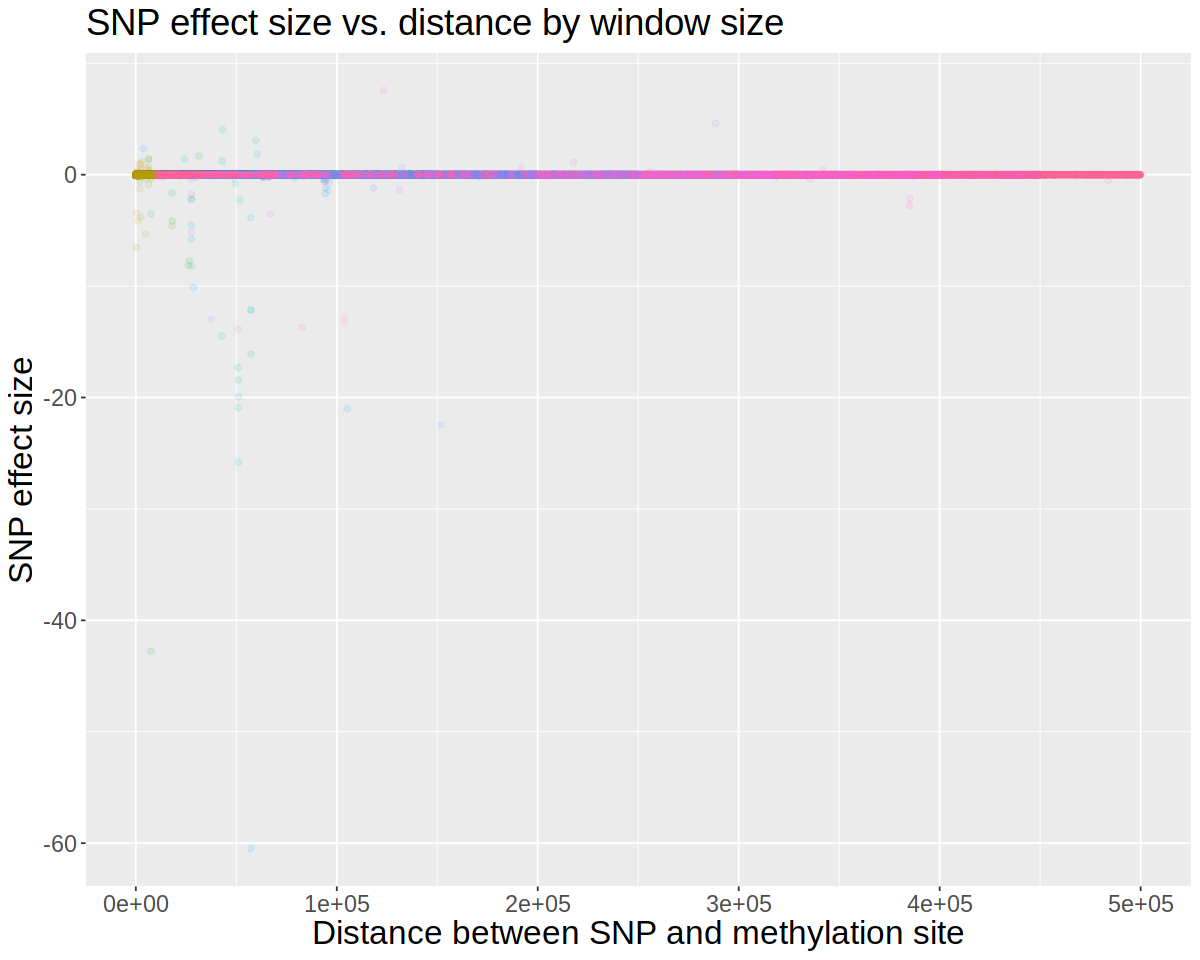

In [35]:
library(ggplot2)

ggplot(snp_df, aes(x = Distance, y = SNP_Weight, color = as.factor(windowSize))) +
  geom_point(alpha = 0.1) +
  #geom_smooth(method = "lm", se = FALSE, size = 2) + # Add trendline
  labs(title = "SNP effect size vs. distance by window size",
       x = "Distance between SNP and methylation site",
       y = "SNP effect size") +  
  theme(legend.position = "none",
        text = element_text(size = 20),
        plot.title = element_text(size = 22),
        axis.title = element_text(size = 20),
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14))

<div class="alert alert-block alert-info">We have some extreme outliers on the lower end for some reason</div>

Warning message:
“Removed 135 rows containing missing values (`geom_point()`).”


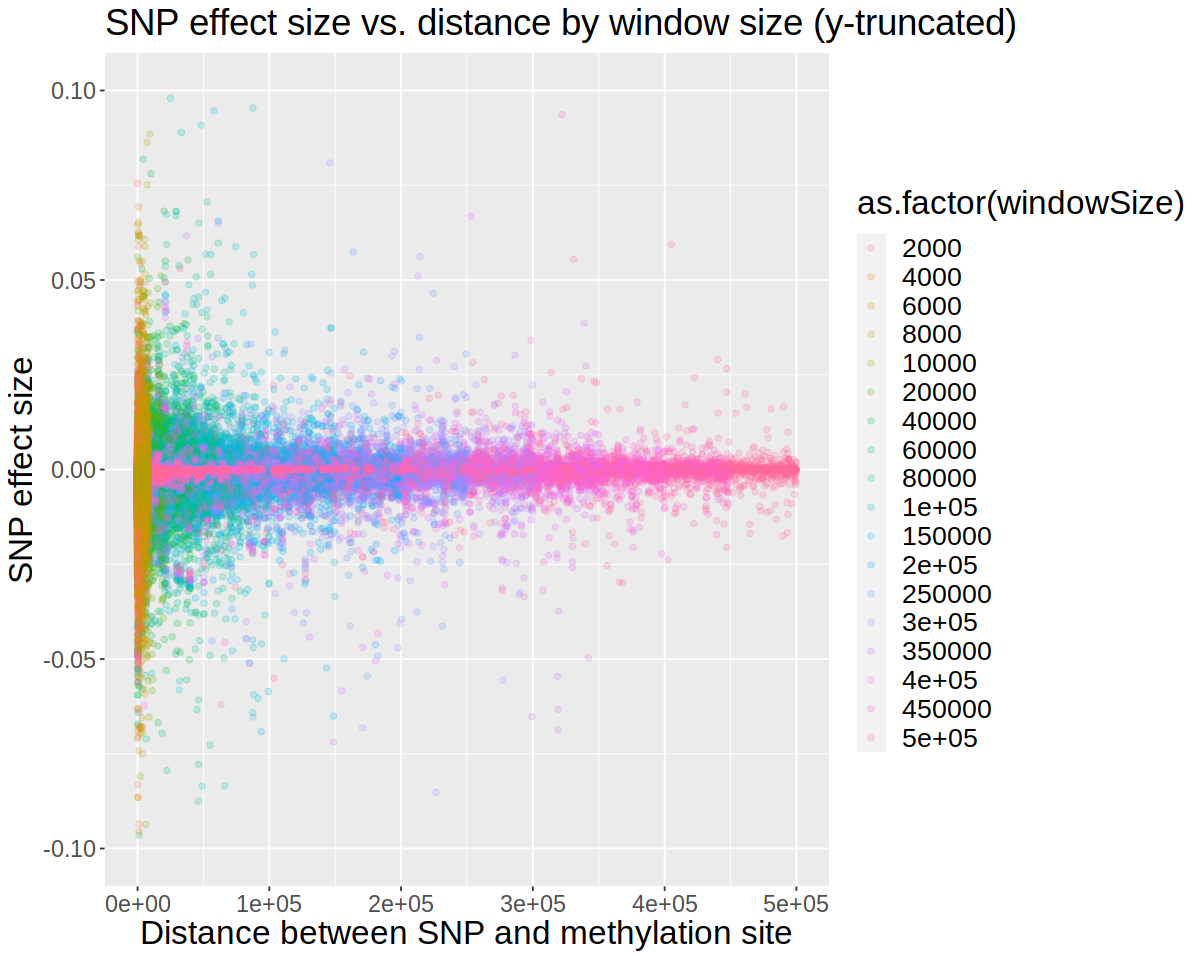

In [36]:
library(ggplot2)

ggplot(snp_df, aes(x = Distance, y = SNP_Weight, color = as.factor(windowSize))) +
  geom_point(alpha = 0.2) +
  #geom_smooth(method = "lm", se = FALSE, size = 2) + # Add trendline
  labs(title = "SNP effect size vs. distance by window size (y-truncated)",
       x = "Distance between SNP and methylation site",
       y = "SNP effect size") +  
  ylim(-0.1, 0.1)+
  theme(text = element_text(size = 20),
        plot.title = element_text(size = 22),
        axis.title = element_text(size = 20),
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14))

Does this trend hold up if we only look at large windows?

Warning message:
“Removed 11 rows containing missing values (`geom_point()`).”


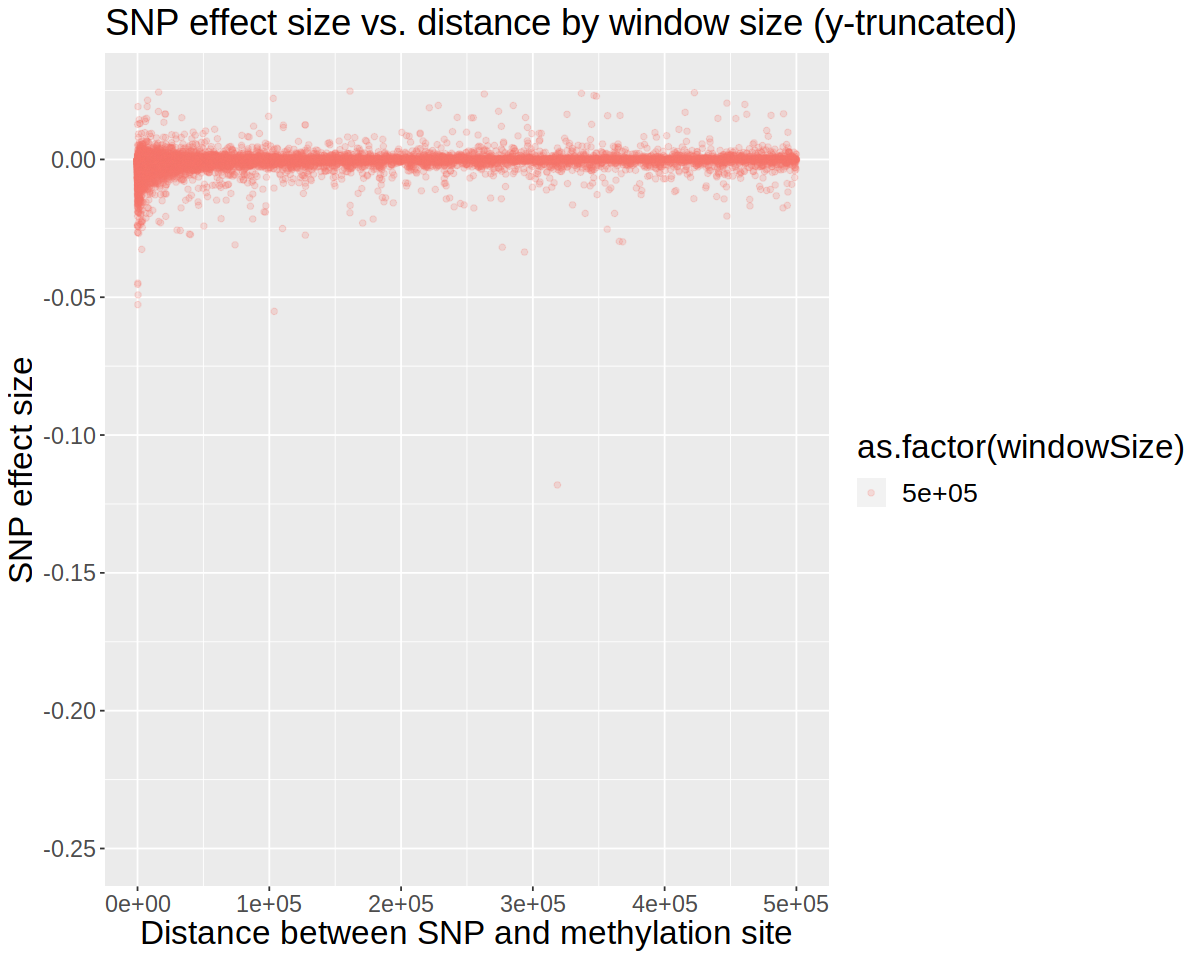

In [37]:
library(ggplot2)

snp_df_subset <- snp_df[which(snp_df$windowSize >= 500000), ]

ggplot(snp_df_subset, aes(x = Distance, y = SNP_Weight, color = as.factor(windowSize))) +
  geom_point(alpha = 0.2) +
  #geom_smooth(method = "lm", se = FALSE, size = 2) + # Add trendline
  labs(title = "SNP effect size vs. distance by window size (y-truncated)",
       x = "Distance between SNP and methylation site",
       y = "SNP effect size") +  
  ylim(-0.25, 0.025)+
  theme(text = element_text(size = 20),
        plot.title = element_text(size = 22),
        axis.title = element_text(size = 20),
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14))

## When window size varies, how similar is correlation for given SNPs

<div class="alert alert-block alert-info">In these plots, each dot represents a SNP included in runs for both window sizes, with cor for each window size shown on a different axis.</div>

In [38]:
levels(factor(snp_df$windowSize))

[1] "2000"   "4000"   "6000"   "8000"   "10000"  "20000"  "40000"  "60000" 
 [9] "80000"  "1e+05"  "150000" "2e+05"  "250000" "3e+05"  "350000" "4e+05" 
[17] "450000" "5e+05"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


R^2: 0.4493374 


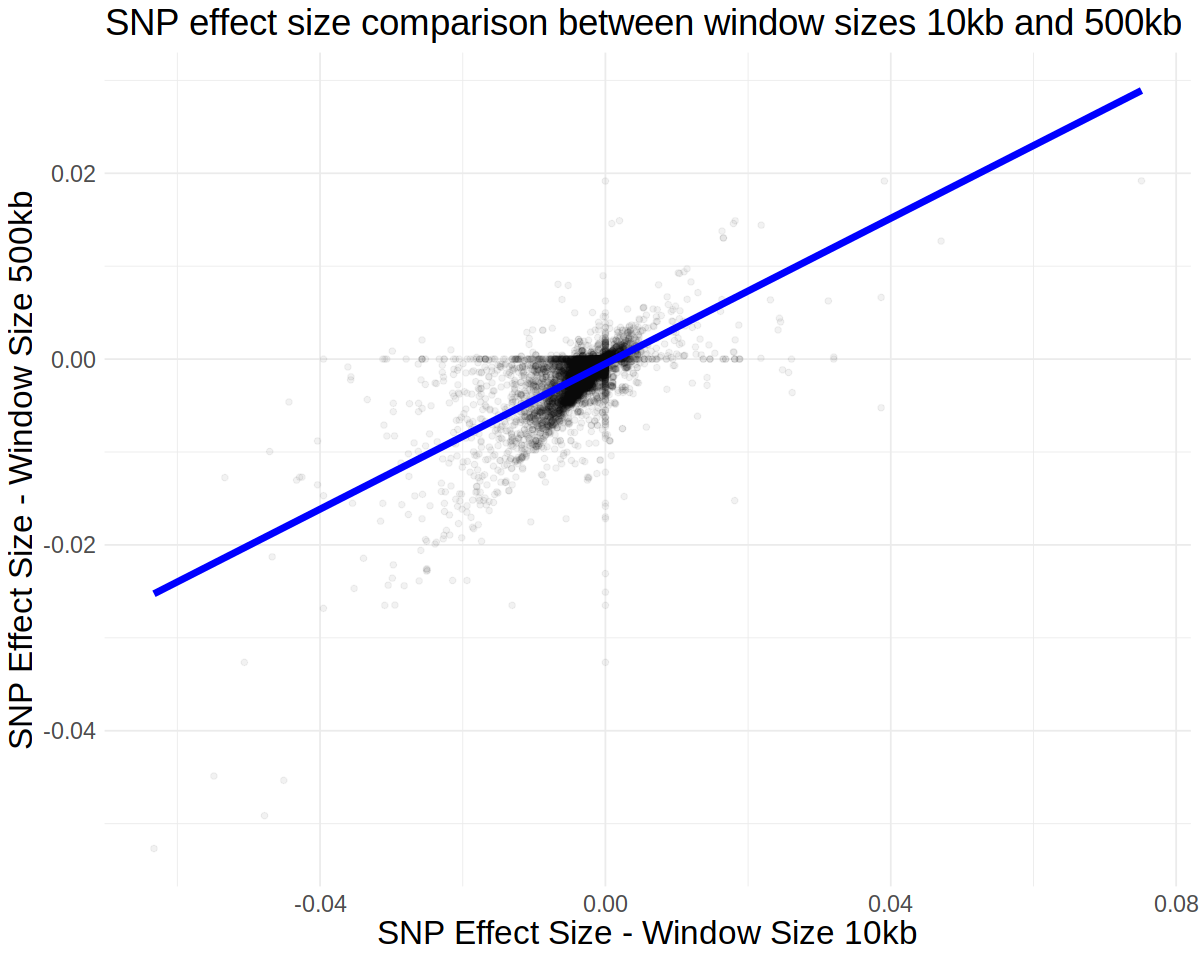

In [39]:
plotSNPEffectSizes <- function(data, labelX, labelY) {
  # Filter for SNPs present in both specified window size labels
  dataX <- subset(data, windowSizeLabel == labelX)
  dataY <- subset(data, windowSizeLabel == labelY)
  
  # Find common SNPs in both window size labels
  commonSNPIDs <- intersect(dataX$SNP_ID, dataY$SNP_ID)
  
  # Subset data for common SNPs
  dataXCommon <- subset(dataX, SNP_ID %in% commonSNPIDs)
  dataYCommon <- subset(dataY, SNP_ID %in% commonSNPIDs)
  
  commonSNPs <- merge(dataXCommon, dataYCommon, by = "SNP_ID", suffixes = c("_x", "_y"))
  
  plot <- ggplot(commonSNPs, aes(x = SNP_Weight_x, y = SNP_Weight_y)) +
    geom_point(alpha = 0.05) +
    geom_smooth(method = "lm", se = FALSE, color = "blue", size = 2) +
    labs(title = paste("SNP effect size comparison between window sizes", labelX, "and", labelY),
         x = paste("SNP Effect Size - Window Size", labelX),
         y = paste("SNP Effect Size - Window Size", labelY)) +
    theme_minimal() +
    theme(legend.position = "none",
          text = element_text(size = 20),
          plot.title = element_text(size = 22),
          axis.title = element_text(size = 20),
          axis.text.x = element_text(size = 14),
          axis.text.y = element_text(size = 14))
  
  print(plot)
  
  # Calculate and print R^2 for linear model of SNP_Weight comparison
  model <- lm(SNP_Weight_y ~ SNP_Weight_x, data = commonSNPs)
  rSquared <- summary(model)$r.squared
  cat("R^2:", rSquared, "\n")
}

plotSNPEffectSizes(snp_df, "10kb", "500kb")


<div class="alert alert-block alert-info">Weak agreement when window sizes are very different</div>

In [40]:
levels(factor(snp_df$windowSize))

[1] "2000"   "4000"   "6000"   "8000"   "10000"  "20000"  "40000"  "60000" 
 [9] "80000"  "1e+05"  "150000" "2e+05"  "250000" "3e+05"  "350000" "4e+05" 
[17] "450000" "5e+05"

`geom_smooth()` using formula = 'y ~ x'


R^2: 0.3755739 


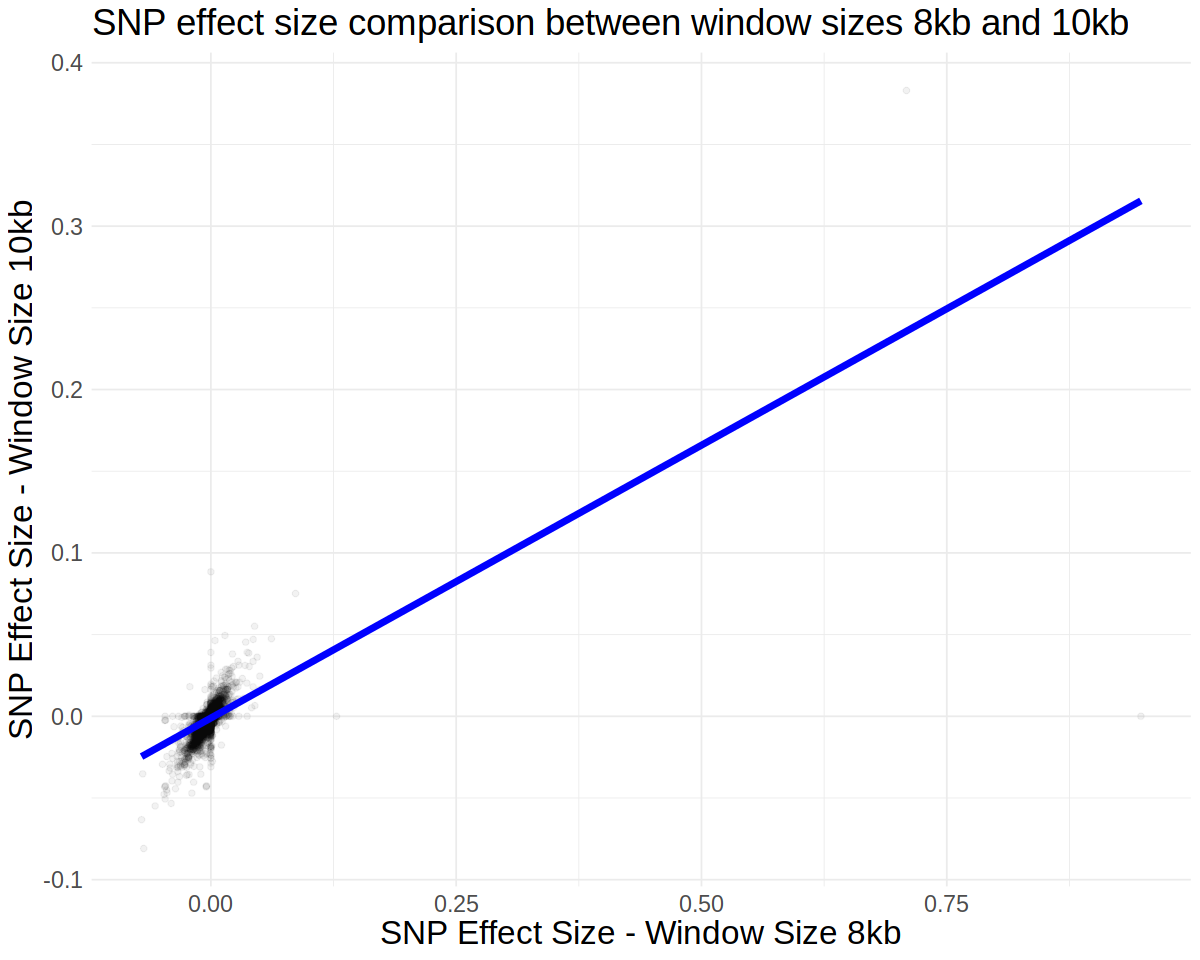

In [46]:
plotSNPEffectSizes(snp_df, "8kb", "10kb")

<div class="alert alert-block alert-info">Agreement is not always stronger when window sizes are closer</div>

## How frequently does each possible window size give best performance for given methylation site?

### Performance according to R

In [42]:
dim(df)[1]/length(levels(factor(df$windowSize)))

[1] 9487.722

In [43]:
colnames(df)

[1] "scaffoldIdentifier"  "methylationPosition" "windowSize"         
 [4] "nSNPs"               "cor"                 "mse"                
 [7] "alpha"               "lambda"              "na_cor"             
[10] "windowSizeLabel"

In [44]:
frequency_of_max_cor <- table(df$windowSize[ave(df$cor, df$methylationPosition, FUN = function(x) seq_along(x) == which.max(x)) == 1])


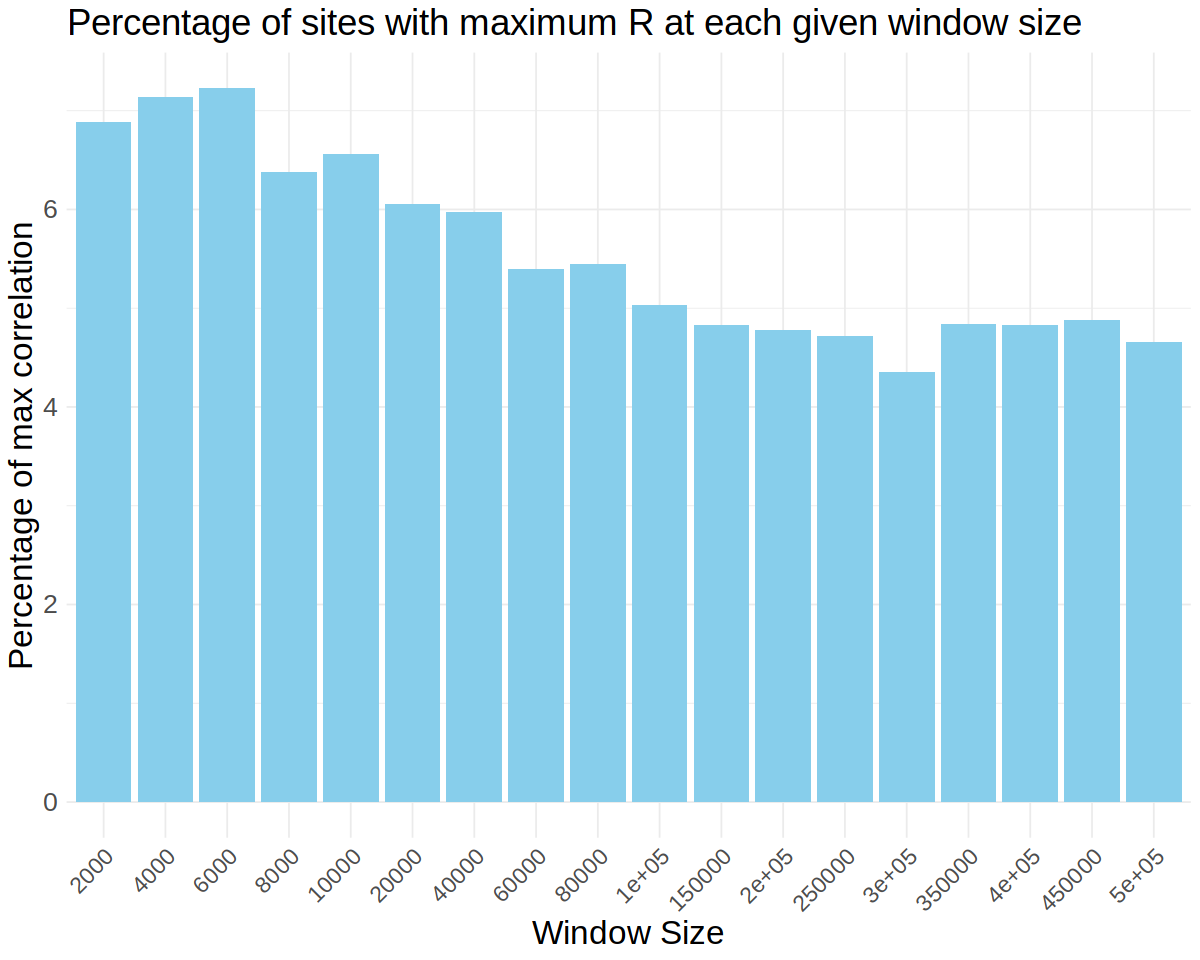

In [45]:
percentage_of_max_cor <- prop.table(frequency_of_max_cor) * 100

percentage_df <- data.frame(
  windowSize = names(percentage_of_max_cor),
  percentage = as.numeric(percentage_of_max_cor)
)

percentage_df$windowSize_numeric <- as.numeric(gsub("kb", "", percentage_df$windowSize))
percentage_df <- percentage_df[order(percentage_df$windowSize_numeric),]

library(ggplot2)
ggplot(percentage_df, aes(x = reorder(windowSize, windowSize_numeric), y = percentage)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  theme_minimal() +
  labs(title = "Percentage of sites with maximum R at each given window size",
       x = "Window Size", 
       y = "Percentage of max correlation") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14)
  )


### Performance according to MSE

In [66]:
frequency_of_max_mse <- table(df$windowSize[ave(df$mse, df$methylationPosition, FUN = function(x) seq_along(x) == which.min(x)) == 1])


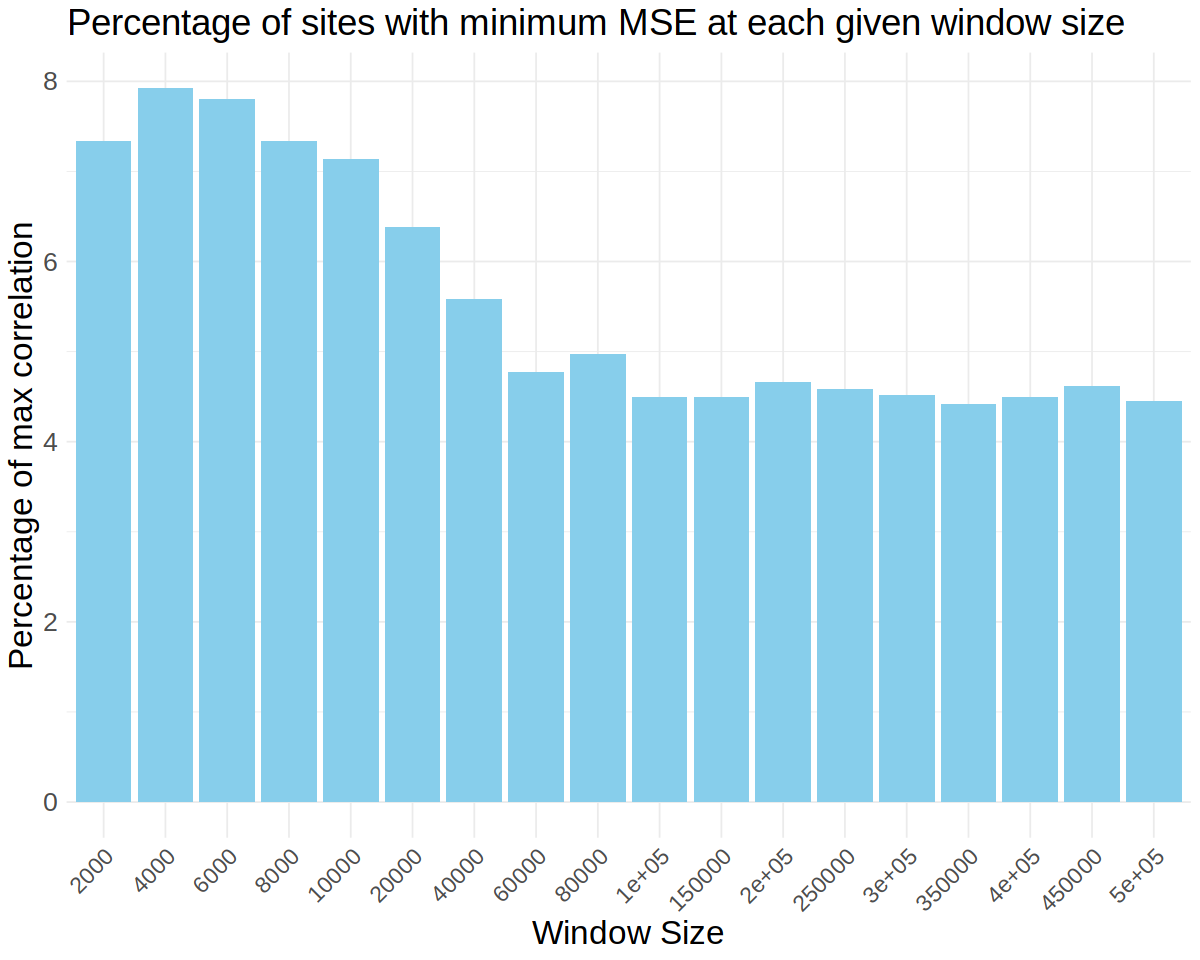

In [67]:
percentage_of_max_mse <- prop.table(frequency_of_max_mse) * 100

percentage_df <- data.frame(
  windowSize = names(percentage_of_max_mse),
  percentage = as.numeric(percentage_of_max_mse)
)

percentage_df$windowSize_numeric <- as.numeric(gsub("kb", "", percentage_df$windowSize))
percentage_df <- percentage_df[order(percentage_df$windowSize_numeric),]

library(ggplot2)
ggplot(percentage_df, aes(x = reorder(windowSize, windowSize_numeric), y = percentage)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  theme_minimal() +
  labs(title = "Percentage of sites with minimum MSE at each given window size",
       x = "Window Size", 
       y = "Percentage of max correlation") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(size = 22),
    axis.title = element_text(size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14)
  )
